In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='whitesmoke'
mpl.rcParams['axes.edgecolor']='white'
mpl.rcParams['axes.linewidth']=3

mpl.rcParams['text.color'] = 'dimgrey'
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

mpl.rcParams["text.usetex"] = True

In [38]:
G=6.67e-11
M=5.972e24
m=7.348e22
D=3.844e8
R=6.371e6
r=1.737e6
mu=m/M
print('mu: ',mu)
Omega=np.sqrt(G*M*(1+mu)/D**3)

mu:  0.012304085733422638


In [291]:
N=128

Y=116e9 # tensile modulus from "Ultra High Molecular Weight Polyethylene Fiber from DSM Dyneema" factbook
L=0.7*D
A=1e-7
k=Y*A/L
print('k: ',k)
#k=0.01
dL=L/N

m=1e4/N

rEarth=np.array([0,-D*mu/(1+mu),0])
rMoon=np.array([0,D/(1+mu),0])
omega=Omega*np.array([0,0,1])
def rDotDot(rs,rDots):
    # gravitaional force from Earth
    rEs=rs-rEarth
    dEs=np.sqrt(np.sum(rEs**2,axis=1))
    earth=-G*M*rEs/dEs[:, np.newaxis]**3
    # gravitaional force from Moon
    rMs=rs-rMoon
    dMs=np.sqrt(np.sum(rMs**2,axis=1))
    moon=-G*M*rMs/dMs[:, np.newaxis]**3
    # centrifugal force (vector cross prodcut requires we specify axis carefully)
    centrifugal=-np.cross(omega, np.cross(omega, rs, axisa=0, axisb=1), axisa=0, axisb=1)
    # coriolis force (same as above)
    coriolis=-np.cross(omega, rDots, axisa=0, axisb=1)
    
    # tension force (a little more complex - depends on displacement from natural length and direction)
    # actually we're interested in the change in tension over the element
    dTension=np.zeros_like(rs)
    # vector between each pair of particles (size N)
    dRs=rs[1:,:]-rs[:-1,:]
    # distance between each pair of particles (size N)
    ds=np.sqrt(np.sum(dRs**2,axis=1))
    # tension force due to each connection
    tensions=(k/m)*dRs*((ds[:,np.newaxis]-dL)/ds[:,np.newaxis])
    #tensions[tensions<0]=0
    # and now have all parts needed to find change in tension (note first and last particles have only 1 tension force acting)
    dTension[1:-1,:]=tensions[1:,:]-tensions[:-1,:]
    dTension[0,:]=tensions[0,:]
    dTension[-1,:]=-tensions[-1,:]
    #dTension[:-1,:]=np.cumsum(tensions,axis=1)
    
    return earth+moon+dTension-(0.1*rDots)
def leapfrog(rs,rDots,dt):
    rDotDots=rDotDot(rs,rDots)
    # the anchor on the moon provides the force (acceleration) needed to keep the anchor point stationary
    anchorForce=-rDotDots[:,-1]
    
    rDots=rDots+rDotDots*dt/2
    rDots[-1,:]=0
    rs=rs+rDots*dt
    rs[-1,:]=np.array([0,(D/(1+mu))-r,0])
    rDotDots=rDotDot(rs,rDots)
    rDots=rDots+rDotDots*dt/2
    rDots[-1,:]=0
    return rs,rDots

nTs=10000

rs=np.zeros((N+1,3))
rDots=np.zeros((N+1,3))
rs[:,1]=np.linspace((D/(1+mu))-r-L,(D/(1+mu))-r,N+1)
ts=np.zeros(nTs)
ys=np.zeros((N+1,nTs))
vs=np.zeros((N+1,nTs))

dt=60 # one second jumps in time
for n in range(nTs):
    #print('___________________________________________________________',n)
    t=n*dt
    ts[n]=t
    rs,rDots=leapfrog(rs,rDots,dt)
    #print(rs/D)
    ys[:,n]=rs[:,1]/D
    vs[:,n]=rDots[:,1]
    if((rs[0,1]/D<0) | (rs[0,1]/D>1)):
        ts[n:]=t
        break

k:  4.3109855804965065e-05


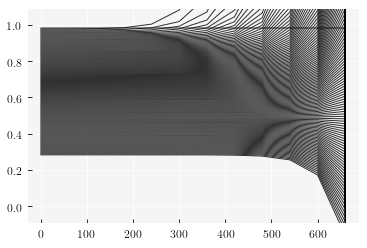

In [293]:
thisPlot=plt.gca()
for i in range(N+1):
    thisPlot.plot(ts,ys[i,:],c='k',lw=1,alpha=0.8)
thisPlot.set_ylim(-0.1,1.1)
#thisPlot.set_xlim(0,40000)
plt.show()

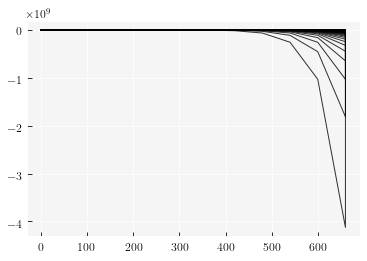

In [296]:
thisPlot=plt.gca()
for i in range(N+1):
    thisPlot.plot(ts,vs[i,:],c='k',lw=1,alpha=0.8)
#thisPlot.set_ylim(-0.01,0.01)
plt.show()